In [1]:
import process as pc
from IPython.core.interactiveshell import InteractiveShell

from sklearn.svm import LinearSVC
#from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt
import joblib
import cv2

import numpy as np

InteractiveShell.ast_node_interactivity = "all"
%config Completer.use_jedi = False

In [2]:
positive_images_path = pc.DATA_PATH+"/img_align_celeba"
negative_images_path = pc.DATA_PATH+"/caltech-101/101_ObjectCategories"

pc.extract_dataset(positive_images_path)
bad_imgs_path_list = pc.extract_dataset(negative_images_path, folder="multi_folders")

Dataset already extracted


In [3]:
n_good_images = 20000
n_bad_images_folder=1000
size_w = size_h = 128

#count bad images:
bad_img_list = []
for fld in bad_imgs_path_list:
    tmp_img_list = pc.load_images(negative_images_path+"/"+fld, number_of_images=n_bad_images_folder, random_seed=7)
    bad_img_list += [negative_images_path+"/"+fld+'/'+img for img in tmp_img_list]

len(bad_img_list)


/home/enrico/Machine_learning/face_detection_project/src/user_warnings.py:4: UserWarning: The requested number of images is greater than the number of images in the folder
  warnings.warn("The requested number of images is greater than the number of images in the folder", UserWarning)


8275

In [4]:
choices = ['HOG', 'SIFT', 'ORB']
print("Choose feature extractor:", flush=True)
for i, choice in enumerate(choices):
    print("{}. {}".format(i+1, choice), flush=True)
choice_features_extractor = str(input())
choice_features_extractor= choice_features_extractor.upper()


if choice_features_extractor in choices:
    idx = choices.index(choice_features_extractor.upper())+1
else:
    print("Invalid choice")
    exit(1)
print("You chose: {}. {}".format(idx, choice_features_extractor.upper()), flush=True)

Choose feature extractor:
1. HOG
2. SIFT
3. ORB
You chose: 1. HOG


In [5]:
bad_patches = pc.extract_patches(bad_img_list, (size_w, size_h), n_patches=25000, random_seed=7)
len(bad_patches)
img_list = pc.load_images(positive_images_path, number_of_images=n_good_images, random_seed=7) 
images = np.empty((n_good_images, size_w, size_h), dtype=np.uint8)
bad_images = np.empty((len(bad_patches), size_w, size_h), dtype=np.uint8)

2


23837

In [6]:
if choice_features_extractor.upper() == 'ORB' or choice_features_extractor.upper() == 'SIFT':
    for i, img in enumerate(img_list):
        image = cv2.imread(pc.DATA_PATH+"/img_align_celeba/"+img)
        images[i, ...] = pc.process_image(image, resize=True, img_resize=(size_w, size_h))


    for i, img in zip(range(len(bad_patches)), bad_patches):
        bad_images[i, ...] = pc.process_image(img, resize=True, img_resize=(size_w, size_h))

else:
    for i, img in enumerate(img_list):
        image = cv2.imread(pc.DATA_PATH+"/img_align_celeba/"+img, cv2.IMREAD_GRAYSCALE)
        images[i, ...] = cv2.resize(image, (size_w, size_h))


    for i, img in zip(range(len(bad_patches)), bad_patches):
        gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
        bad_images[i, ...] = cv2.resize(gray, (size_w, size_h))

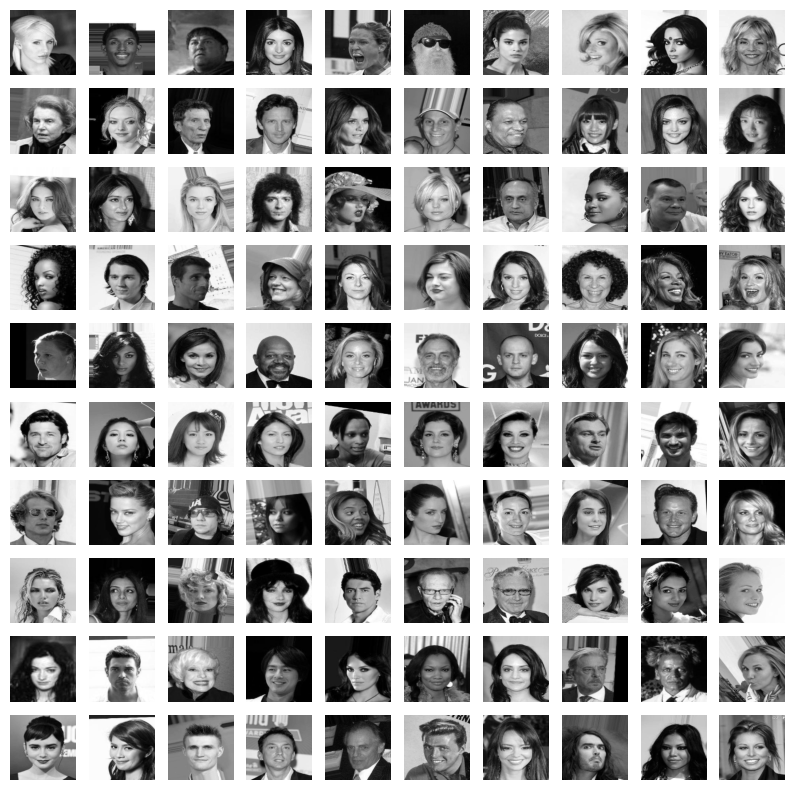

In [7]:
fig, ax = plt.subplots(10, 10, figsize=(10, 10))
for i in range(10):
    for j in range(10):
        ax[i, j].imshow(images[i*10+j], cmap='gray')
        ax[i, j].axis('off')
plt.show();

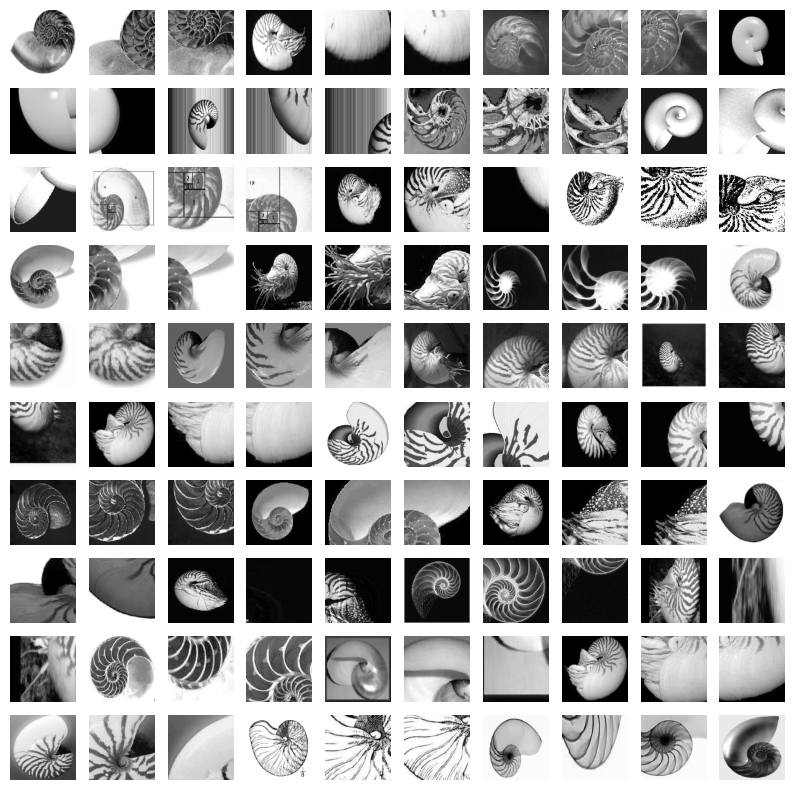

In [8]:
fig, ax = plt.subplots(10, 10, figsize=(10, 10))
for i in range(10):
    for j in range(10):
        ax[i, j].imshow(bad_images[i*10+j], cmap='gray')
        ax[i, j].axis('off')
plt.show();

In [9]:
images.shape
bad_images.shape

(20000, 128, 128)

(23837, 128, 128)

In [10]:
dataset = np.concatenate((images, bad_images), axis=0)
dataset.shape

(43837, 128, 128)

In [13]:
good_samples = n_good_images
bad_samples = bad_images.shape[0]
n_keypoints = 32
n_features = 128#256
ftr_shape = n_keypoints*n_features
features = None

init = False
for i, img in enumerate(dataset):
   if choice_features_extractor == "ORB":
      _, features = pc.extract_ORB_features(img, n_keypoints=32)
      if features is None:
         if i < good_samples:
               good_samples -= 1
         else:
            bad_samples -= 1
         continue
   if choice_features_extractor == "SIFT":
      kp, features = pc.extract_SIFT_features(img, n_optimal_keypoints=n_keypoints)
      if len(kp) < n_keypoints:
         if i < good_samples:
               good_samples -= 1
         else:
            bad_samples -= 1
         continue
   if choice_features_extractor == "HOG":
      ftr_shape = 8100
      features = pc.extract_HOG_features(img, cell_size=(8, 8), block_size=(2, 2), nbins=9)
      if features is None:
         if i < good_samples:
               good_samples -= 1
         else:
            bad_samples -= 1
         continue
      
   features = features.flatten()
   if features.shape[0] == ftr_shape:
      if not init:
         X = np.array([features])
         init = True
      else:
         X = np.append(X, [features], axis=0)
   else:
      if i < good_samples:
         features.shape
         print("good sample")
         good_samples -= 1
      else:
         print("bad sample")
         bad_samples -= 1        

In [ ]:
good_samples
bad_samples
y = np.concatenate((np.ones(good_samples), np.zeros(bad_samples))) 
X.shape
y.shape

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.02, random_state=7)

In [ ]:
X_train.shape
y_train.shape

X_train[0]
y_train[0]


In [ ]:
X_train_pca = X_train
X_test_pca = X_test

In [ ]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
X_train_scaled = scaler.fit_transform(X_train_pca)
X_test_scaled = scaler.transform(X_test_pca)
X_train_scaled[0]

In [ ]:
param_grid = {  'C' : [np.power(10., i) for i in range(-2, 2)],
                'max_iter' : [7500],
                'random_state' : [7],
                'dual' : ['auto'],
                'verbose': [1]  }

grid_searh = GridSearchCV(LinearSVC(), param_grid, cv=5, n_jobs=4)
grid_searh.fit(X_train_scaled, y_train)
grid_searh.best_params_

In [ ]:
best_svc = grid_searh.best_estimator_

best_svc.score(X_train_scaled, y_train)

best_svc.score(X_test_scaled, y_test)

In [ ]:
y_pred = best_svc.predict(X_train_scaled)
accuracy = accuracy_score(y_train, y_pred)
print("Accuracy test:", accuracy)


y_pred = best_svc.predict(X_test_scaled)
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy test:", accuracy)

In [ ]:
X_test_scaled[0]

In [ ]:
pipeline_save_path = pc.DATA_PATH+"/hog_features.pkl"

from sklearn.pipeline import Pipeline

pipeline = Pipeline(
    steps=[
        ('preprocess', pc.process_image),
        ('normalize', scaler),
        ('extract_features', pc.extract_SIFT_features),
        ('svc', best_svc)  
    ])

joblib.dump(
    pipeline, pipeline_save_path
    )